## Run these cells before running the actual colab notebook

(Uncomment and run these cells)

In [39]:
#!git clone https://github.com/ManavMNair/Quantum-image-encryption.git


In [40]:
#%cd Quantum-image-encryption

In [41]:


#!pip install -r requirements.txt

In [42]:
#!pip install pylatexenc

## Imports

In [43]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from quantum.neqr import encode_neqr, reconstruct_neqr_image
#----------------------------------------------------------------------------------------------------------------
# Uncomment and Call these functions for encoding with MCQI. The reconstruction quality is depends on the shot count. 
# As the shot count increases SSIM increases. But significantly lower reconstruction quality compared to NEQR's
# from quantum.mcqi import encode_mcqi, reconstruct_mcqi_image
#----------------------------------------------------------------------------------------------------------------

from quantum.scrambling import (
    quantum_scramble,
    quantum_permutation,
    reverse_quantum_scrambling,
    reverse_quantum_permutation
)

from chaos.qrng import qrng
from chaos.henon import henon_map
from chaos.hybrid_map import generate_chaotic_key_image

from dna.dna_encode import dna_encode
from dna.dna_decode import dna_decrypt

from utils.metrics import compute_psnr_ssim


## Configuration Parameters

In [44]:
IMAGE_PATH = "data/Te-gl_0017.png"
IMG_SIZE = 128
# SHOTS = 65536
SHOTS = 100000
SEED_BITS = 16


## Load and display original image

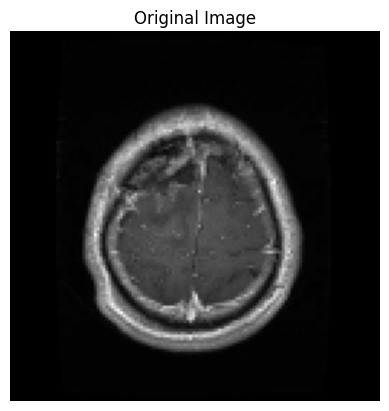

Image shape: (128, 128)


In [45]:
img = cv.imread(IMAGE_PATH, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
img = img.astype(np.uint8)

plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

print("Image shape:", img.shape)


## Quantum-Chaotic key generation

In [46]:
x0 = qrng(SEED_BITS) / (2**SEED_BITS - 1)
y0 = qrng(SEED_BITS) / (2**SEED_BITS - 1)

x, y = henon_map(x0, y0, n_iter=IMG_SIZE)

bpk = np.floor(x * 256).astype(np.uint8)
ksk = np.floor(y * 256).astype(np.uint8)

print("BPK key (sample):", bpk[:10])
print("KSK key (sample):", ksk[:10])


BPK key (sample): [ 48  63  65 230  52 171 110   0   0   0]
KSK key (sample): [ 79  14  95 122 197  15 128 212   0   0]


c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\chaos\henon.py:10: RuntimeWarning: overflow encountered in scalar power
  x[i] = 1 - alpha * (x[i-1] ** 2) + y[i-1]
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_6668\2022344900.py:6: RuntimeWarning: invalid value encountered in cast
  bpk = np.floor(x * 256).astype(np.uint8)
C:\Users\MANEESH M NAIR\AppData\Local\Temp\ipykernel_6668\2022344900.py:7: RuntimeWarning: invalid value encountered in cast
  ksk = np.floor(y * 256).astype(np.uint8)


## NEQR Encoding

In [47]:
qc = encode_neqr(img)

print("Encoded to NEQR")
# qc.draw("mpl")


Encoded to NEQR


## Quantum Scrambling

In [48]:
num_position_qubits = int(2 * np.log2(IMG_SIZE))

qc_scrambled = quantum_scramble(qc, bpk, num_position_qubits)

print(" Applied Quantum Scrambling")
# qc_scrambled.draw("mpl")


 Applied Quantum Scrambling


## Quantum Permutation

In [49]:
qc_permuted = quantum_permutation(qc_scrambled, ksk, num_position_qubits)

print("Applied Quantum Permutation:")
# qc_permuted.draw("mpl")


Applied Quantum Permutation:


## Measurement → Scrambled Quantum Image

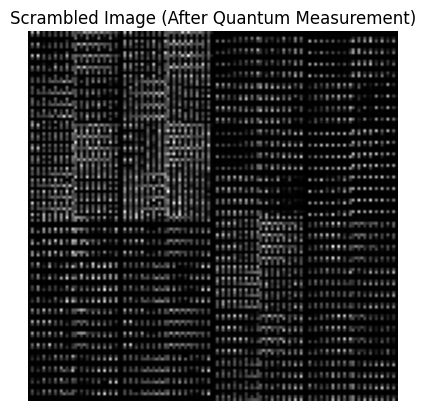

In [50]:
scrambled_quantum_img = reconstruct_neqr_image(
    qc_permuted, IMG_SIZE, IMG_SIZE, shots=SHOTS
)

plt.imshow(scrambled_quantum_img, cmap="gray")
plt.title("Scrambled Image (After Quantum Measurement)")
plt.axis("off")
plt.show()


## Circuit Resource Analysis

In [51]:
print("Total qubits :", qc_permuted.num_qubits)
print("Circuit depth:", qc_permuted.depth())
print("Circuit width:", qc_permuted.width())


Total qubits : 22


Circuit depth: 50483
Circuit width: 22


## Classical DNA Encryption

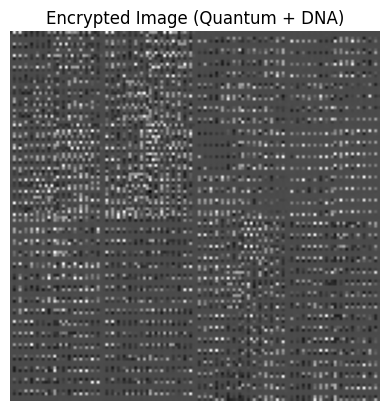

In [52]:
DNi0, DNi1, DNi2, DNi3 = dna_encode(scrambled_quantum_img, ksk)

KH = generate_chaotic_key_image(IMG_SIZE, IMG_SIZE)
DKi0, DKi1, DKi2, DKi3 = dna_encode(KH, ksk)

CMedi = (
    (DNi0 ^ DKi0) << 6 |
    (DNi1 ^ DKi1) << 4 |
    (DNi2 ^ DKi2) << 2 |
    (DNi3 ^ DKi3)
).astype(np.uint8)

plt.imshow(CMedi, cmap="gray")
plt.title("Encrypted Image (Quantum + DNA)")
plt.axis("off")
plt.show()


DNA Decryption (Recover Scrambled Image)

c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:46: RuntimeWarning: overflow encountered in scalar subtract
  DNi0[i, j] = (DNi0[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:50: RuntimeWarning: overflow encountered in scalar subtract
  DNi2[i, j] = (DNi2[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:52: RuntimeWarning: overflow encountered in scalar subtract
  DNi3[i, j] = (DNi3[i, j] - key) % 4
c:\Users\MANEESH M NAIR\Desktop\DUK\S4\Project\Quantum Image Encryption\dna\dna_decode.py:48: RuntimeWarning: overflow encountered in scalar subtract
  DNi1[i, j] = (DNi1[i, j] - key) % 4


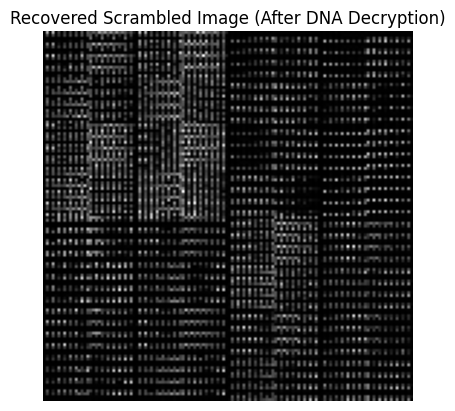

In [53]:
scrambled_recovered = dna_decrypt(
    CMedi, DKi0, DKi1, DKi2, DKi3, ksk
)

plt.imshow(scrambled_recovered, cmap="gray")
plt.title("Recovered Scrambled Image (After DNA Decryption)")
plt.axis("off")
plt.show()



## Re-encode & Reverse Quantum Operations

In [54]:
qc_re = encode_neqr(scrambled_recovered)

qc_re = reverse_quantum_permutation(qc_re, ksk, num_position_qubits)
qc_re = reverse_quantum_scrambling(qc_re, bpk, num_position_qubits)

print("Quantum Circuit Reversed")
# qc_re.draw("mpl")


Quantum Circuit Reversed


## Final Quantum Reconstruction

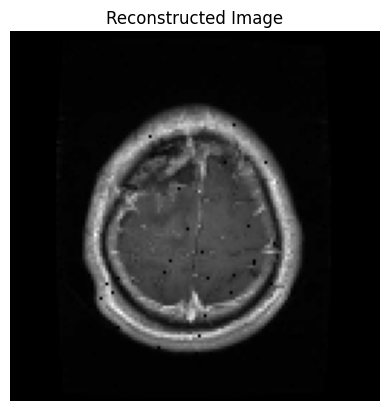

In [55]:
reconstructed_img = reconstruct_neqr_image(
    qc_re, IMG_SIZE, IMG_SIZE, shots=SHOTS
)

plt.imshow(reconstructed_img, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()


## Quantitative Evaluation (PSNR & SSIM)

In [56]:
psnr_val, ssim_val = compute_psnr_ssim(img, reconstructed_img)

print("Shots :", SHOTS)
print(f"PSNR  : {psnr_val:.2f} dB")
print(f"SSIM  : {ssim_val:.4f}")


Shots : 100000
PSNR  : 38.62 dB
SSIM  : 0.9875


Original vs Reconstructed(decrypted)

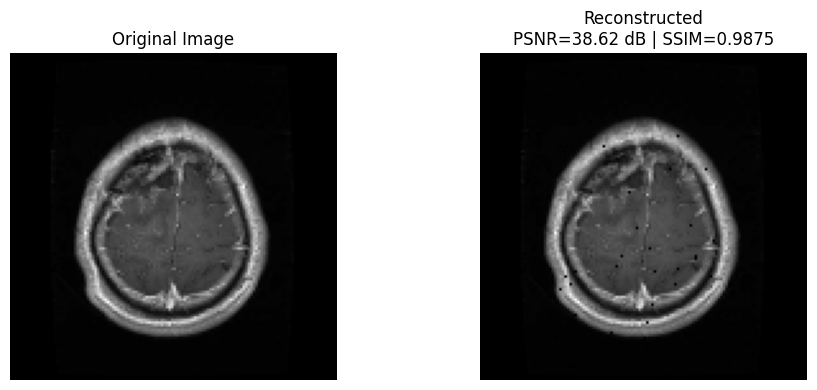

In [57]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap="gray")
plt.title(f"Reconstructed\nPSNR={psnr_val:.2f} dB | SSIM={ssim_val:.4f}")
plt.axis("off")

plt.tight_layout()
plt.show()
